## Business Context & Objectives

This analysis explores transactional e-commerce data to understand sales performance, customer behavior, and revenue drivers. The goal is to generate actionable insights that can support business decisions related to product strategy, customer retention, and geographic expansion.


Key business questions addressed in this analysis include:


*   **Which products and customers drive the majority of revenue?**

*   **How does customer purchasing behavior vary across segments?**

*   **Are there observable trends in sales, cancellations, or seasonality?**

*   **How can customers be segmented for targeted marketing strategies?**

## Data Overview

The dataset contains historical e-commerce transaction records, including invoice details, product information, quantities, prices, customer identifiers, and geographic attributes. Each row represents a single product-level transaction within an order.The data is obtained from The UCI Machine Learning Repository. Here is the link: https://archive.ics.uci.edu/dataset/352/online+retail

Variables Information
* **InvoiceNo**: a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation
* **StockCode**: a 5-digit integral number uniquely assigned to each distinct product
* **Description**: product name
* **Quantity**: the quantities of each product (item) per transaction
* **InvoiceDate**: the day and time when each transaction was generated
* **UnitPrice**: product price per unit. Unit in sterling
* **CustomerID**: a 5-digit integral number uniquely assigned to each customer
* **Country**: the name of the country where each customer resides

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [63]:
raw_data = pd.read_csv('./data.csv', encoding='unicode_escape')
raw_data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [35]:
raw_data.shape

(541909, 8)

In [36]:
# Data information
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [37]:
print("Time coverage from ", raw_data['InvoiceDate'].min(), "-", raw_data['InvoiceDate'].max())

Time coverage from  1/10/2011 10:04 - 9/9/2011 9:52


Each row represents a product-level line item within an order rather than a unique transaction. As a result, the dataset does not contain a single-column primary key. Instead, orders are identified by `InvoiceNo`, which can appear multiple times when an order contains multiple products.


In [38]:
raw_data['InvoiceNo'].nunique(), raw_data.shape[0]

(25900, 541909)

In [39]:
print("number of duplicated rows: ", raw_data.duplicated().sum())

number of duplicated rows:  5268


In [40]:
# Some products appear multiple time in the same invoice
print("number of duplicates in (invoiceID, StockCode): ", raw_data[['InvoiceNo', 'StockCode']].duplicated().sum())

number of duplicates in (invoiceID, StockCode):  10684


## Data Cleaning & Assumptions

To ensure analytical accuracy, the following data cleaning steps were applied:


*   Removed transactions with missing CustomerID, as these cannot be attributed to identifiable customers
*   Excluded cancelled transactions, identified by invoice numbers starting with "C" and negative quantities, to prevent revenue distortion.

*   Verified that pricing and quantity values were within reasonable ranges to reduce the impact of outliers or data entry errors






In [41]:
raw_data.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [42]:
df_cleaning = raw_data.copy()

missing_customer_pct = df_cleaning['CustomerID'].isna().mean()
print("missing customerID in :", round(missing_customer_pct*100,2), "%")

missing customerID in : 24.93 %


In [43]:
# The cancellation rate is 1.7% among all transactions
df_cleaning['IsCancelled'] = df_cleaning['InvoiceNo'].astype(str).str.startswith('C')
df_cleaning['IsCancelled'].value_counts(normalize = True)

,proportion
IsCancelled,
False,0.982861
True,0.017139


### Valid Sales Definition

To ensure revenue accuracy, a valid sale is defined as a transaction that:
- Is not cancelled  
- Has a positive quantity  
- Has a positive unit price


In [44]:
df_cleaning['IsValidSale'] = (~df_cleaning['IsCancelled']) & \
                                (df_cleaning['Quantity'] > 0) & \
                                (df_cleaning['UnitPrice'] > 0)
df_cleaning['IsValidSale'].value_counts(normalize = True)

,proportion
IsValidSale,
True,0.978216
False,0.021784


### Assumptions

The following assumptions are applied throughout the analysis:

- Revenue is calculated as `Quantity × UnitPrice`
- Cancelled transactions do not contribute to revenue
- Each row represents a product-level line item within an order
- Customer behavior analysis requires a valid `CustomerID`
- The dataset reflects historical transactional behavior and may not represent future demand

## Data Preparation & Feature Engineering

After cleaning and validating the raw data, additional features and analytical datasets were created to support exploratory analysis. These transformations improve interpretability, enable aggregation, and prepare the data for customer and product-level analysis.



In [45]:
df_cleaning.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,IsValidSale
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,False,True
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,False,True
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,False,True
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,False,True
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,False,True


In [46]:
df_prep = df_cleaning.copy()

# Ensure datetime
df_prep['InvoiceDate'] = pd.to_datetime(df_prep['InvoiceDate'], errors='coerce')

# Revenue feature
df_prep['Sales'] = df_prep['Quantity'] * df_prep['UnitPrice']

# Time features
df_prep['Year'] = df_prep['InvoiceDate'].dt.year
df_prep['Month'] = df_prep['InvoiceDate'].dt.to_period('M').astype(str)
df_prep['MonthNum'] = df_prep['InvoiceDate'].dt.month
df_prep.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,IsValidSale,Sales,Year,Month,MonthNum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,True,15.30,2010,2010-12,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,True,20.34,2010,2010-12,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,True,22.00,2010,2010-12,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,True,20.34,2010,2010-12,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,True,20.34,2010,2010-12,12


### Product Description Standardization

Product descriptions are standardized using `StockCode` as a stable identifier. Missing or inconsistent descriptions are mapped to the most common known description for each product to improve readability in reporting and visualization.


In [47]:
# Build common Description mapping
desc_map = (
    df_prep
    .dropna(subset=['Description'])
    .groupby('StockCode')['Description']
    .agg(lambda x: x.mode().iloc[0])
)

# Fill missing descriptions
df_prep['Description'] = df_prep['Description'].fillna(
    df_prep['StockCode'].map(desc_map)
)

df_prep['Description'].isna().sum()


np.int64(112)

In [48]:
df_prep['Description'] = df_prep['Description'].fillna('Unknown / Unmapped')
df_prep['Description'].isna().sum()

np.int64(0)

### Clean Analytical Views

Multiple cleaned datasets are created to support different analytical perspectives:
- Transaction-level trends
- Revenue calculations
- Customer behavior analysis

In [49]:
# Transaction-level (includes missing CustomerID)
df_txn = df_prep.copy()

# Revenue-safe completed sales
df_sales = df_prep[df_prep['IsValidSale']].copy()

# Customer-level dataset
df_cust = df_sales.dropna(subset=['CustomerID']).copy()

## Exploratory Analysis

### Sales & Revenue Overview

An initial revenue analysis was conducted to understand overall sales performance and transaction distribution. This includes total revenue trends, order volumes, and high-level sales patterns across time.

Include:

*   **Total revenue**
*   **Monthly revenue trend**
*   **Order counts**

In [50]:
df_sales.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,IsValidSale,Sales,Year,Month,MonthNum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,True,15.30,2010,2010-12,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,True,20.34,2010,2010-12,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,True,22.00,2010,2010-12,12


In [51]:
total_revenue = df_sales['Sales'].sum()
print("Total Revenue: £{:,.2f}".format(total_revenue))

total_orders = df_sales['InvoiceNo'].nunique()
print("Total Orders: {:,}".format(total_orders))

total_customers = df_sales['CustomerID'].nunique()
print("Total Customers: {:,}".format(total_customers))

Total Revenue: £10,666,684.54
Total Orders: 19,960
Total Customers: 4,338


In [52]:
monthly_revenue = (df_sales.groupby("Month", as_index=False)
                   .agg(
                       revenue = ('Sales', 'sum'),
                       orders = ('InvoiceNo', 'nunique')
                   )
                   .sort_values('Month')
)
monthly_revenue.head()

,Month,revenue,orders
0,2010-12,823746.140,1559
1,2011-01,691364.560,1086
2,2011-02,523631.890,1100
3,2011-03,717639.360,1454
4,2011-04,537808.621,1246


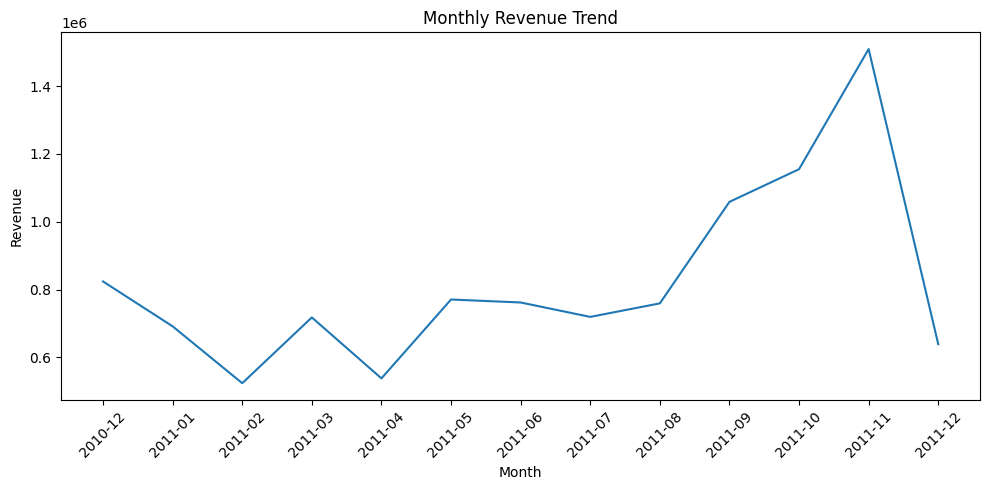

In [53]:
plt.figure(figsize=(10,5))
plt.plot(monthly_revenue['Month'], monthly_revenue['revenue'])
plt.xticks(rotation=45)
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()

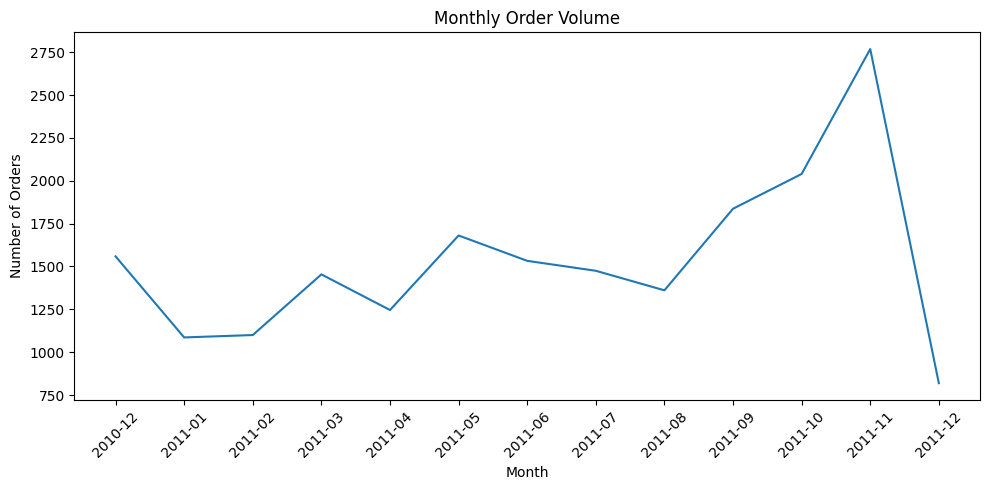

In [54]:
plt.figure(figsize=(10,5))
plt.plot(monthly_revenue['Month'], monthly_revenue['orders'])
plt.xticks(rotation=45)
plt.title('Monthly Order Volume')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

#### Revenue and Order Volume Trends

The monthly revenue and order volume plots show a clear upward trend beginning in September 2011, with both metrics peaking in November 2011. This indicates that the increase in revenue during this period is primarily driven by higher order volume rather than isolated high-value transactions.

The sharp decline observed in December 2011 is likely attributable to partial-month data coverage rather than an actual drop in business performance. As such, December 2011 should be interpreted with caution in any time-based comparisons.

Overall, the aligned movement of revenue and order volume suggests strong seasonal effects in late Q3 and Q4, motivating further investigation into product mix, customer behavior, and geographic drivers during this peak period in subsequent analyses.

### Product Performance Analysis

Product-level analysis reveals that revenue is concentrated among a small subset of products. While top-performing SKUs drive a significant portion of sales, long-tail products contribute marginally to overall revenue.

This concentration suggests potential dependency risks, as disruptions to top-selling products could materially impact business performance.

During initial product-level analysis, several items such as postage, discounts, and administrative charges appeared among the top-selling StockCodes. These items do not represent customer-selected merchandise and would distort product demand analysis if treated as products.

To address this, StockCodes were reviewed and categorized into sellable products (including physical goods and digital products such as gift vouchers) versus operational or financial line items (e.g., shipping fees, discounts, commissions).


In [55]:
non_physical_stockcodes = df_sales[~df_sales['StockCode'].str.match(r'^\d', na=False)][['StockCode', 'Description']]
non_physical_stockcodes.drop_duplicates(inplace=True)
non_physical_stockcodes

,StockCode,Description
45,POST,POSTAGE
1423,C2,CARRIAGE
1814,DOT,DOTCOM POSTAGE
2239,M,Manual
4406,BANK CHARGES,Bank Charges
15017,AMAZONFEE,AMAZON FEE
21326,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT
24906,DCGS0003,BOXED GLASS ASHTRAY
38248,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00
40052,DCGS0070,CAMOUFLAGE DOG COLLAR


In [56]:
df_prep['ItemType'] = np.select(
    [
        df_prep['StockCode'].isin(['POST','DOT','C2','AMAZONFEE','BANK CHARGES','B','CRUK','D','M','m']),
        df_prep['StockCode'].str.startswith('gift_', na=False)
    ],
    [
        'Operational',
        'Digital Product'
    ],
    default='Physical Product'
)

In [57]:
df_prep['ItemType'].value_counts()

,count
ItemType,
Physical Product,539026
Operational,2849
Digital Product,34


In [58]:
df_sales = df_prep[df_prep['IsValidSale']].copy()
df_product_sales = df_sales[df_sales['ItemType'] != 'Operational'].copy()

In [59]:
product_performance = (
    df_product_sales.groupby(['StockCode', 'Description'], as_index=False)
    .agg(
        total_quantity=('Quantity', 'sum'),
        total_revenue=('Sales', 'sum')
    )
)

product_performance.head()

,StockCode,Description,total_quantity,total_revenue
0,10002,INFLATABLE POLITICAL GLOBE,860,759.89
1,10080,GROOVY CACTUS INFLATABLE,303,119.09
2,10120,DOGGY RUBBER,193,40.53
3,10123C,HEARTS WRAPPING TAPE,5,3.25
4,10124A,SPOTS ON RED BOOKCOVER TAPE,16,6.72


In [60]:
df_sales

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,IsValidSale,Sales,Year,Month,MonthNum,ItemType
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,True,15.30,2010,2010-12,12,Physical Product
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,True,20.34,2010,2010-12,12,Physical Product
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,True,22.00,2010,2010-12,12,Physical Product
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,True,20.34,2010,2010-12,12,Physical Product
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,True,20.34,2010,2010-12,12,Physical Product
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,False,True,10.20,2011,2011-12,12,Physical Product
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,False,True,12.60,2011,2011-12,12,Physical Product
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,False,True,16.60,2011,2011-12,12,Physical Product
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,False,True,16.60,2011,2011-12,12,Physical Product


In [61]:
project_path = '/content/drive/MyDrive/Portfolio/Customer Segmentation/'
df_sales.to_csv(
    f'{project_path}/sales.csv',
    index=False
)

#### Rank by Quantity

In [ ]:
top_by_quantity = product_performance.sort_values(
    'total_quantity', ascending=False
)
top_by_quantity.head(10)

,StockCode,Description,total_quantity,total_revenue
2668,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,168469.60
2123,23166,MEDIUM CERAMIC TOP STORAGE JAR,78033,81700.92
3128,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,55047,13841.85
3619,85099B,JUMBO BAG RED RETROSPOT,48474,94340.05
3640,85123A,WHITE HANGING HEART T-LIGHT HOLDER,37599,104340.29
1129,22197,POPCORN HOLDER,36761,34298.87
3416,84879,ASSORTED COLOUR BIRD ORNAMENT,36461,59094.93
448,21212,PACK OF 72 RETROSPOT CAKE CASES,36419,21259.10
2029,23084,RABBIT NIGHT LIGHT,30788,66964.99
1405,22492,MINI PAINT SET VINTAGE,26633,16937.82


#### Rank by Revenue

In [ ]:
top_by_revenue = product_performance.sort_values(
    'total_revenue', ascending=False
)
top_by_revenue.head(10)

,StockCode,Description,total_quantity,total_revenue
1340,22423,REGENCY CAKESTAND 3 TIER,13879,174484.74
2668,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,168469.60
3640,85123A,WHITE HANGING HEART T-LIGHT HOLDER,37599,104340.29
2877,47566,PARTY BUNTING,18295,99504.33
3619,85099B,JUMBO BAG RED RETROSPOT,48474,94340.05
2123,23166,MEDIUM CERAMIC TOP STORAGE JAR,78033,81700.92
2029,23084,RABBIT NIGHT LIGHT,30788,66964.99
1022,22086,PAPER CHAIN KIT 50'S CHRISTMAS,19355,64952.29
3416,84879,ASSORTED COLOUR BIRD ORNAMENT,36461,59094.93
3059,79321,CHILLI LIGHTS,10306,54117.76


#### Product Performance Insights

Product performance analysis shows a clear distinction between volume-driven and revenue-driven items. Several products rank highly in both total quantity sold and total revenue, indicating consistent, broad-based demand. For example, items such as *REGENCY CAKESTAND 3 TIER* and *WHITE HANGING HEART T-LIGHT HOLDER* combine strong unit sales with high revenue contribution, making them core revenue drivers within the product portfolio.

At the same time, certain products generate high sales volumes but comparatively lower revenue. *PAPER CRAFT, LITTLE BIRDIE* stands out with the highest quantity sold but slightly lower revenue than some lower-volume products, suggesting a lower unit price and a volume-led sales strategy. This contrast highlights how pricing plays a critical role in determining revenue impact beyond sheer demand.

Overall, the product mix is dominated by physical merchandise, which accounts for the vast majority of transactions, while digital products such as gift vouchers represent a negligible share of sales activity. Operational line items were excluded from this analysis to ensure that results reflect true merchandise demand rather than fees or adjustments.

These findings suggest opportunities to manage the product portfolio strategically by balancing high-volume, lower-priced items that drive traffic with higher-value products that contribute disproportion



### Geographic Sales Distribution

Sales performance varies significantly across countries, with a small number of regions accounting for the majority of revenue. Differences in average order value and purchase frequency suggest that customer behavior is not uniform across markets.

#### Revenue Contribution by Country

In [ ]:
country_revenue = (
    df_sales
    .groupby('Country', as_index=False)
    .agg(
        total_revenue=('Sales', 'sum'),
        total_orders=('InvoiceNo', 'nunique'),
        total_customers=('CustomerID', 'nunique')
    )
    .sort_values('total_revenue', ascending=False)
)

country_revenue.head()

,Country,total_revenue,total_orders,total_customers
36,United Kingdom,9025222.084,18019,3920
24,Netherlands,285446.340,94,9
10,EIRE,283453.960,288,3
14,Germany,228867.140,457,94
13,France,209715.110,392,87


#### Revenue Concentration

In [ ]:
total_revenue = country_revenue['total_revenue'].sum()
top_5_country_share = (
    country_revenue.head(5)
    .assign(
        revenue_share_pct = lambda x: round((x['total_revenue'] / total_revenue) * 100,2))
    [['Country', 'total_revenue', 'revenue_share_pct']]
)
top_5_country_share

,Country,total_revenue,revenue_share_pct
36,United Kingdom,9025222.084,84.61
24,Netherlands,285446.340,2.68
10,EIRE,283453.960,2.66
14,Germany,228867.140,2.15
13,France,209715.110,1.97


#### Orders vs Revenue by Country

In [ ]:
country_revenue['avg_revenue_per_order'] = (
    country_revenue['total_revenue'] / country_revenue['total_orders']
)

country_revenue.sort_values(
    'avg_revenue_per_order', ascending=False
).head(10)

,Country,total_revenue,total_orders,total_customers,avg_revenue_per_order
30,Singapore,21279.29,7,1,3039.898571
24,Netherlands,285446.34,94,9,3036.663191
0,Australia,138521.31,57,9,2430.198421
20,Japan,37416.37,19,8,1969.282632
21,Lebanon,1693.88,1,1,1693.880000
16,Hong Kong,15691.80,11,0,1426.527273
4,Brazil,1143.60,1,1,1143.600000
32,Sweden,38378.33,36,8,1066.064722
33,Switzerland,57089.90,54,21,1057.220370
9,Denmark,18955.34,18,9,1053.074444


#### Orders vs Revenue by Country

In [ ]:
country_revenue['avg_revenue_per_order'] = (
    country_revenue['total_revenue'] / country_revenue['total_orders']
)

country_revenue.sort_values(
    'avg_revenue_per_order', ascending=False
).head(10)

,Country,total_revenue,total_orders,total_customers,avg_revenue_per_order
30,Singapore,21279.29,7,1,3039.898571
24,Netherlands,285446.34,94,9,3036.663191
0,Australia,138521.31,57,9,2430.198421
20,Japan,37416.37,19,8,1969.282632
21,Lebanon,1693.88,1,1,1693.880000
16,Hong Kong,15691.80,11,0,1426.527273
4,Brazil,1143.60,1,1,1143.600000
32,Sweden,38378.33,36,8,1066.064722
33,Switzerland,57089.90,54,21,1057.220370
9,Denmark,18955.34,18,9,1053.074444


#### Geographic analysis Insight
Geographic analysis shows that while total revenue is concentrated in a small number of countries, purchasing behavior varies significantly across regions. Countries such as the Netherlands and Australia contribute substantial overall revenue driven by moderate order volumes and multiple active customers, indicating relatively established demand in these markets.

In contrast, several countries exhibit exceptionally high average revenue per order despite low transaction counts. For example, Singapore and the Netherlands both record average order values exceeding £3,000, suggesting that customers in these regions tend to place fewer but significantly larger orders. Similar patterns are observed in Australia and Japan, where higher order values compensate for lower overall order volumes.

Some markets, including Lebanon and Brazil, show isolated high-value transactions with only a single order and customer, indicating sporadic or non-recurring activity rather than sustained demand. Additionally, countries such as Switzerland and Sweden demonstrate a balance between order volume and order value, reflecting more stable and diversified purchasing behavior.

Overall, these patterns suggest that revenue differences across countries are driven not only by transaction volume but also by distinct purchasing behaviors. High average order value markets may benefit from targeted account-based or enterprise-focused strategies, while higher-volume markets may present opportunities for scaling customer acquisition and repeat purchasing.



### Customer Purchasing Behavior

Customer-level analysis shows a highly skewed distribution of purchasing behavior. A majority of customers place infrequent or low-value orders, while a smaller group of repeat customers contributes disproportionately to total revenue.

This insight highlights the importance of retention-focused strategies and motivates further customer segmentation.

In [ ]:
customer_summary = (
    df_cust.groupby('CustomerID', as_index=False)
    .agg(
        total_orders=('InvoiceNo', 'nunique'),
        total_revenue=('Sales','sum'),
        total_quantity=('Quantity', 'sum')
        )
)
customer_summary.head()

,CustomerID,total_orders,total_revenue,total_quantity
0,12346.0,1,77183.60,74215
1,12347.0,7,4310.00,2458
2,12348.0,4,1797.24,2341
3,12349.0,1,1757.55,631
4,12350.0,1,334.40,197


#### One-Time vs Repeat Customers


In [ ]:
customer_summary['customer_type'] = np.where(
    customer_summary['total_orders'] == 1,
    'One-time',
    'Repeat'
)

customer_type_dist = customer_summary['customer_type'].value_counts(normalize=True)
customer_type_dist

,proportion
customer_type,
Repeat,0.655832
One-time,0.344168


#### Revenue Concentration Across Customers


In [ ]:
customer_summary_sorted = customer_summary.sort_values(
    'total_revenue', ascending = False
).reset_index()

customer_summary_sorted['cum_revenue'] = customer_summary_sorted['total_revenue'].cumsum()
customer_summary_sorted['cum_revenue_pct'] = customer_summary_sorted['cum_revenue'] / customer_summary_sorted['total_revenue'].sum()
customer_summary_sorted

,index,CustomerID,total_orders,total_revenue,total_quantity,customer_type,cum_revenue,cum_revenue_pct
0,1689,14646.0,73,280206.02,196915,Repeat,280206.020,0.031444
1,4201,18102.0,60,259657.30,64124,Repeat,539863.320,0.060581
2,3728,17450.0,46,194550.79,69993,Repeat,734414.110,0.082413
3,3008,16446.0,2,168472.50,80997,Repeat,902886.610,0.101318
4,1879,14911.0,201,143825.06,80265,Repeat,1046711.670,0.117457
...,...,...,...,...,...,...,...,...
4333,3323,16878.0,1,13.30,12,One-time,8911378.304,0.999997
4334,4098,17956.0,1,12.75,1,One-time,8911391.054,0.999998
4335,3014,16454.0,2,6.90,3,Repeat,8911397.954,0.999999
4336,1793,14792.0,1,6.20,2,One-time,8911404.154,1.000000


In [ ]:
# Share of revenue from top X% customers
for pct in [0.01, 0.05, 0.10]:
    idx = int(len(customer_summary_sorted) * pct)
    share = customer_summary_sorted.loc[idx, 'cum_revenue_pct']
    print(f"Top {int(pct*100)}% customers account for ~{share:.2%} of revenue")

Top 1% customers account for ~32.00% of revenue
Top 5% customers account for ~50.38% of revenue
Top 10% customers account for ~61.38% of revenue


#### Orders vs Spending Behavior


In [ ]:
customer_summary['avg_order_value'] = customer_summary['total_revenue'] / customer_summary['total_orders']
customer_summary[['total_orders','total_revenue', 'avg_order_value']] .describe()

,total_orders,total_revenue,avg_order_value
count,4338.000000,4338.000000,4338.000000
mean,4.272015,2054.266460,419.166289
std,7.697998,8989.230441,1796.537944
min,1.000000,3.750000,3.450000
25%,1.000000,307.415000,178.625000
50%,2.000000,674.485000,293.900000
75%,5.000000,1661.740000,430.113750
max,209.000000,280206.020000,84236.250000


#### Customer Behavior Insight
 Customer behavior analysis reveals a highly concentrated revenue structure. The top 1% of customers account for approximately 32% of total revenue, while the top 5% and 10% contribute over 50% and 60% of revenue respectively. This indicates a strong dependence on a small subset of high-value customers, exposing the business to potential revenue risk if these customers churn.

Order frequency and spending distributions further highlight this imbalance. While the median customer places only two orders with total spending under £700, a small group of customers exhibits extremely high purchasing activity, with some placing over 200 orders and generating more than £280,000 in revenue. The wide gap between median and maximum values, along with large standard deviations, suggests a long-tailed customer value distribution.

These findings emphasize the strategic importance of customer retention and targeted engagement for high-value customers, while also indicating opportunities to nurture lower-frequency customers toward repeat purchasing behavior. The observed patterns provide a strong foundation for subsequent customer segmentation using Recency, Frequency, and Monetary (RFM) analysis.


## Preparing for Customer Segmentation

Previous analysis indicates that customer value is highly skewed, with a small proportion of customers contributing a disproportionate share of total revenue. To better understand and differentiate customer behavior, a structured customer segmentation approach is required.

This section prepares the dataset for segmentation by constructing key behavioral features at the customer level.


### RFM

Recency, Frequency, and Monetary (RFM) analysis is used as the segmentation framework because it captures three fundamental dimensions of customer behavior:
- **Recency**: How recently a customer made a purchase
- **Frequency**: How often a customer purchases
- **Monetary**: How much a customer spends


In [ ]:
analysis_date = df_cust['InvoiceDate'].max() + pd.Timedelta(days=1)
analysis_date

Timestamp('2011-12-10 12:50:00')

In [ ]:
rfm = (
    df_cust.groupby('CustomerID')
    .agg(
        recency = ('InvoiceDate', lambda x: (analysis_date - x.max()).days),
        frequency = ('InvoiceNo', 'nunique'),
        monetary = ('Sales', 'sum')
    )
)
rfm.head()

,recency,frequency,monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [ ]:
rfm[['recency', 'frequency', 'monetary']].describe(
    percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]
)

,recency,frequency,monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
90%,263.000000,9.000000,3646.531000
95%,312.000000,13.000000,5841.843000
99%,369.000000,30.000000,19880.995700
max,374.000000,209.000000,280206.020000


In [ ]:
customer_master = (
    df_cust
    .groupby('CustomerID', as_index=False)
    .agg(
        recency_days=('InvoiceDate', lambda x: (analysis_date - x.max()).days),
        frequency=('InvoiceNo', 'nunique'),
        monetary=('Sales', 'sum'),
        total_quantity=('Quantity', 'sum'),
        avg_order_value=('Sales', lambda x: x.sum() / x.nunique()),
        first_purchase_date=('InvoiceDate', 'min'),
        last_purchase_date=('InvoiceDate', 'max'),
        primary_country=('Country', lambda x: x.mode().iloc[0])
    )
)

customer_master.head()

,CustomerID,recency_days,frequency,monetary,total_quantity,avg_order_value,first_purchase_date,last_purchase_date,primary_country
0,12346.0,326,1,77183.60,74215,77183.600000,2011-01-18 10:01:00,2011-01-18 10:01:00,United Kingdom
1,12347.0,2,7,4310.00,2458,76.964286,2010-12-07 14:57:00,2011-12-07 15:52:00,Iceland
2,12348.0,75,4,1797.24,2341,112.327500,2010-12-16 19:09:00,2011-09-25 13:13:00,Finland
3,12349.0,19,1,1757.55,631,41.846429,2011-11-21 09:51:00,2011-11-21 09:51:00,Italy
4,12350.0,310,1,334.40,197,37.155556,2011-02-02 16:01:00,2011-02-02 16:01:00,Norway


## Key Insights & Next Steps

Key Insights:


*   Revenue is highly concentrated among a small subset of products and customers
*   Repeat customers drive a disproportionate share of total sales
*   Repeat customers drive a disproportionate share of total sales

Next Steps:

*   Apply customer segmentation to support targeted marketing strategies
*   Develop dashboards to monitor product performance and customer retention
*   Explore predictive models for customer lifetime value or demand forecasting
